In [31]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"ayushimehrotra123","key":"5739f2d0b63b057c29700575e302ac01"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100%|██████████████████████████████████████| 7.25G/7.25G [04:16<00:00, 30.2MB/s]
100%|██████████████████████████████████████| 7.25G/7.25G [04:16<00:00, 30.3MB/s]


In [3]:
import zipfile 
with zipfile.ZipFile('./diabetic-retinopathy-resized.zip', 'r') as zip_ref:
    zip_ref.extractall('./eye-cancer')

## Install Dependencies

In [4]:
from IPython.display import clear_output
!pip install torch
!pip install torchvision
!pip install captum
!pip install opencv-python
!pip install seaborn
!pip install matplotlib
!pip install cleverhans
!pip install cachetools
!pip install pandas
!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y
clear_output()

In [61]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import seaborn as sea
import copy
import os
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
from torch import optim,nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from tqdm.notebook import tqdm
from PIL import Image

# from mlxtend.plotting import plot_confusion_matrix
# from sklearn.metrics import confusion_matrix
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Data Preprocessing

In [59]:
def seed_everything(seed = 23):
    # tests
    assert isinstance(seed, int), 'seed has to be an integer'
    
    # randomness
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

image_size = 256
#IMAGE PREPROCESSING

def prepare_image(path, 
                  sigmaX         = 10, 
                  do_random_crop = False):
    
    '''
    Preprocess image
    '''
    
    # import image
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # perform smart crops
    image = crop_black(image, tol = 7)
    if do_random_crop == True:
        image = random_crop(image, size = (0.9, 1))
    
    # resize and color
    image = cv2.resize(image, (int(image_size), int(image_size)))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    
    # circular crop
    image = circle_crop(image, sigmaX = sigmaX)

    # convert to tensor    
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image

def crop_black(img, 
               tol = 7):
    
    '''
    Perform automatic crop of black areas
    '''
    
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        
        if (check_shape == 0): 
            return img 
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img  = np.stack([img1, img2, img3], axis = -1)
            return img

def circle_crop(img, 
                sigmaX = 10):   
    
    '''
    Perform circular crop around image center
    '''
        
    height, width, depth = img.shape
    
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape
    
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness = -1)
    
    img = cv2.bitwise_and(img, img, mask = circle_img)
    return img 

def random_crop(img, 
                size = (0.9, 1)):
    
    '''
    Random crop
    '''

    height, width, depth = img.shape
    
    cut = 1 - random.uniform(size[0], size[1])
    
    i = random.randint(0, int(cut * height))
    j = random.randint(0, int(cut * width))
    h = i + int((1 - cut) * height)
    w = j + int((1 - cut) * width)

    img = img[i:h, j:w, :]    
    
    return img

class EyeData(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None, do_random_crop = True, itype = '.png'):
        self.data      = data
        self.directory = directory
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.itype = itype
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + self.itype)
        image    = prepare_image(img_name, do_random_crop = self.do_random_crop)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}
    
class Data(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None, do_random_crop = True, itype = '.png'):
        self.data      = data
        self.directory = directory
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.itype = itype
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + self.itype)
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_black(image, tol = 7)
        image = cv2.resize(image, (int(image_size), int(image_size)))
        image = circle_crop(image, sigmaX = 10)
        image = torch.tensor(image)
        image = image.permute(2, 1, 0)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}
seed = 23
seed_everything(seed)

In [57]:
train = pd.read_csv('eye-cancer/trainLabels.csv')
train.columns = ['id_code', 'diagnosis']

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['diagnosis'].value_counts())

(35126, 2) (35108, 4)
---------------
0    25810
2     5292
1     2443
3      873
4      708
Name: diagnosis, dtype: int64


In [64]:
sample_trans = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])
sample = Data(data       = train.iloc[0:10], 
                      directory  = 'eye-cancer/resized_train/resized_train',
                      transform  = sample_trans,
                      itype ='.jpeg')

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = 10, 
                                            shuffle     = False, 
                                            num_workers = 4)


# placeholder
image_stats = []

# import loop
for index, observation in tqdm(train.iterrows(), total = len(train)):
    
    # import image
    img = cv2.imread('eye-cancer/resized_train/resized_train/{}.jpeg'.format(observation['id_code']))

    # compute stats
    height, width, channels = img.shape
    ratio = width / height
    
    # save
    image_stats.append(np.array((observation['diagnosis'], height, width, channels, ratio)))

# construct DF
image_stats = pd.DataFrame(image_stats)
image_stats.columns = ['diagnosis', 'height', 'width', 'channels', 'ratio']

batch_size = 16
image_size = 256

# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor()
                                 ])

# validation transformations
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])

# test transformations
test_trans = valid_trans

sample = EyeData(data       = train.iloc[0:10], 
                      directory  = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                      transform  = train_trans,
                      itype ='.jpeg')

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = batch_size, 
                                            shuffle     = True, 
                                            num_workers = 4)

  0%|          | 0/35126 [00:00<?, ?it/s]

In [67]:
num_classes = 5
learning_rate = 1e-4
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_train = train
data_valid = train

# create datasets
train_dataset = EyeData(data      = data_train, 
                             directory = 'eye-cancer/resized_train/resized_train',
                             transform = train_trans,
                             itype ='.jpeg')

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = True, 
                                           num_workers = 4)

## Model

In [73]:
from torchvision.models import inception_v3

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

model_ft = inception_v3(pretrained=True)

In [69]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_criterion = torch.nn.CrossEntropyLoss()

In [74]:
for epoch in range(2):
    ### PREPARATION

    # timer
    epoch_start = time.time()

    # reset losses
    trn_loss = 0.0
    val_loss = 0.0

    # placeholders
    fold_preds = np.zeros((len(data_valid), 5))


    #TRAINING

    # switch regime
    model.train()

    # loop through batches
    for batch_i, data in enumerate(train_loader):

        # extract inputs and labels
        inputs = data['image']
        labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)
        optimizer.zero_grad()

        # forward and backward pass
        with torch.set_grad_enabled(True):
            preds = model(inputs)
            loss  = criterion(preds, labels)
            loss.backward()
            optimizer.step()

        # compute loss
        trn_loss += loss.item() * inputs.size(0)
        
        
    #INFERENCE

    # switch regime
    model.eval()
    
    # loop through batches
    for batch_i, data in enumerate(train_loader):
        
        # extract inputs and labels
        inputs = data['image']
        labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)

        # compute predictions
        with torch.set_grad_enabled(False):
            preds = model(inputs).detach()
            fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = preds.cpu().numpy()

        # compute loss
        loss      = criterion(preds, labels)
        val_loss += loss.item() * inputs.size(0)
        
    # save predictions
    oof_preds = fold_preds

    # scheduler step
    scheduler.step()


    #EVALUATION

    # evaluate performance
    fold_preds_round = fold_preds.argmax(axis = 1)
    val_kappa = metrics.cohen_kappa_score(data_valid['diagnosis'], fold_preds_round.astype('int'), weights = 'quadratic')

    # save perfoirmance values
    val_kappas.append(val_kappa)
    val_losses.append(val_loss / len(data_valid))
    trn_losses.append(trn_loss / len(data_train))


    #EARLY STOPPING

    # display info
    print('- epoch {}/{} | lr = {} | trn_loss = {:.4f} | val_loss = {:.4f} | val_kappa = {:.4f} | {:.2f} min'.format(
        epoch + 1, max_epochs, scheduler.get_lr()[len(scheduler.get_lr()) - 1],
        trn_loss / len(data_train), val_loss / len(data_valid), val_kappa,
        (time.time() - epoch_start) / 60))

    # check if there is any improvement
    if epoch > 0:       
        if val_kappas[epoch] < val_kappas[epoch - bad_epochs - 1]:
            bad_epochs += 1
        else:
            bad_epochs = 0

    # save model weights if improvement
    if bad_epochs == 0:
        oof_preds_best = oof_preds.copy()
        torch.save(model.state_dict(), 'models/model_{}.bin'.format(model_name))

    # break if early stop
    if bad_epochs == early_stop:
        print('Early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
            np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
        print('')
        break

    # break if max epochs
    if epoch == (max_epochs - 1):
        print('Did not met early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
            np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
        print('')
        break


# load best predictions
oof_preds = oof_preds_best

# print performance
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

RuntimeError: Calculated padded input size per channel: (4 x 4). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

In [46]:
def check_accuracy(model, loader):
    model.eval()
    
    correct_output = 0
    total_output = 0
    
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)
            
            score = model(x)
            _,predictions = score.max(1)
            
            correct_output += (y==predictions).sum()
            total_output += predictions.shape[0]
    model.train()
    print(f"out of {total_output} , total correct: {correct_output} with an accuracy of {float(correct_output/total_output)*100}") 

In [47]:
check_accuracy(model, test_dataloader) 

  0%|          | 0/157 [00:00<?, ?it/s]

out of 5000 , total correct: 3677 with an accuracy of 73.53999614715576


In [ ]:
73.17999601364136

## Attacks

In [48]:
!pip install captum
!pip install cleverhans
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import GradientShap
from captum.attr import GuidedGradCam
from captum.attr import LimeBase
from captum.attr import KernelShap
from captum.attr import Occlusion
from captum.attr import visualization as viz
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent
)

NameError: name 'clear_output' is not defined

In [49]:
def compute_mean_abs_dev(attr): 
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        avg = np.mean(a)
        deviation = a - avg 
        absolute_deviation = np.abs(deviation)
        result = np.mean(absolute_deviation)
        scores.append(result)
    return scores    
def compute_median_abs_dev(attr): 
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        med = np.median(a)
        deviation = a - med 
        abs_deviation = np.abs(deviation)
        result = np.median(abs_deviation)
        scores.append(result)
    return scores 
def compute_iqr(attr):
    #inter-quartile range
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        score_75 = np.percentile(a, 75)
        score_25 = np.percentile(a, 25)
        score_qt = score_75 - score_25
        scores.append(score_qt)
    return scores
    
def compute_coef_var(attr):
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        m = np.mean(a)
        st = np.std(attr[i])
        sc = m/st
        scores.append(sc)
    return scores

def compute_coef_iqr(attr):
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        score_75 = np.percentile(a, 75)
        score_25 = np.percentile(a, 25)
        score_qt = (score_75 - score_25)/(score_75 + score_25)
        scores.append(score_qt)
    return scores
    

In [50]:
gc.collect()
torch.cuda.empty_cache()

dataiter = iter(train_dataloader)

igmedianAbs_ben = []
igmeanAbs_ben = []
igiqr_ben = []
igcoef_var_ben=[]
igcoef_iqr_ben = []

igmedianAbs_bena = []
igmeanAbs_bena = []
igiqr_bena = []
igcoef_var_bena=[]
igcoef_iqr_bena = []

for i in range(5):
    images, labels = next(dataiter)
    images = images.to(device)
    labels = labels.to(device)
    for ind in range(32):
        input1 = images[ind].unsqueeze(0)
        x_logits = model(images)
        ig = IntegratedGradients(model)
        a_batch_benign = ig.attribute(input1, target=labels[ind]).sum(axis=1).cpu().detach().numpy()
        igmeanAbs_ben += compute_mean_abs_dev(a_batch_benign)
        igmedianAbs_ben += compute_median_abs_dev(a_batch_benign)
        igiqr_ben += compute_iqr(a_batch_benign)
        igcoef_var_ben += compute_coef_var(a_batch_benign)
        igcoef_iqr_ben += compute_coef_iqr(a_batch_benign)
        # torch.cuda.empty_cache()
        images_pgd = fast_gradient_method(model, input1, 0.1, np.inf)
        _, y_pred_pgd = model(input1).max(1)
        # index = (y_pred_pgd != labels)
        # pgd_images = images_pgd[index]
        # y_pred_pgd = y_pred_pgd[index]
        a_batch_attack = ig.attribute(inputs=images_pgd, target=y_pred_pgd).sum(axis=1).cpu().detach().numpy()
        igmeanAbs_bena += compute_mean_abs_dev(a_batch_attack)
        igmedianAbs_bena += compute_median_abs_dev(a_batch_attack)
        igiqr_bena += compute_iqr(a_batch_attack)
        igcoef_var_bena += compute_coef_var(a_batch_attack)
        igcoef_iqr_bena += compute_coef_iqr(a_batch_attack)
    gc.collect()
    torch.cuda.empty_cache()


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 768, 1, 1])

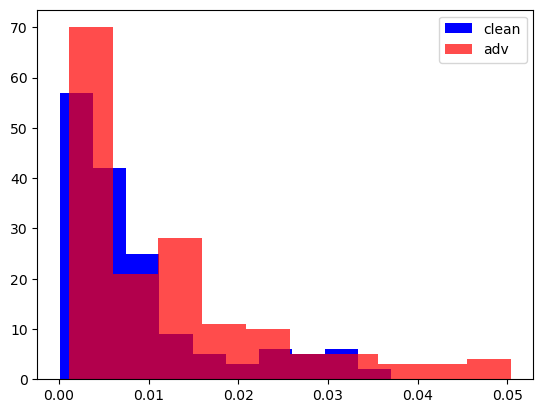

In [60]:
plt.hist(igiqr_ben, label='clean', color='blue')
plt.hist(igiqr_bena, label='adv', alpha=0.7, color='red')
plt.legend()
plt.show()